### CONFIG:

In [1]:
UPDATE_SCORES = True
TRAK_SAVE_DIR = "TRAK/trak_results_lora"
IS_LORA = True

from utils.config import Project_Config, Model_Config, CIFAR_10_Config, LoRA_Model_Config

project_config = Project_Config(
    IS_CUDA = True,
    IS_WINDOWS = False,
)

if IS_LORA:
    model_config = LoRA_Model_Config(
        PROJECT_CONFIG=project_config,
        MODEL_DIR="sd1-cifar10-v2-lora",
        NUM_CHECKPOINTS=10,
        ITERATIONS_PER_CHECKPOINT=10000,
    )
else:
    model_config = Model_Config(
        PROJECT_CONFIG=project_config,
        MODEL_DIR="sd1-cifar10-v2",
        NUM_CHECKPOINTS=10,
        ITERATIONS_PER_CHECKPOINT=10000,
    )

dataset_config = CIFAR_10_Config(new_image_column_name="image",
                                 new_caption_column_name="label_txt")

### Imports:

In [2]:
import torch
from transformers import CLIPTokenizer, CLIPTextModel
from diffusers import AutoencoderKL, UNet2DConditionModel
from torchvision import transforms
from tqdm import tqdm
from torch.utils.data import DataLoader
from datasets import load_dataset, Dataset

/home/joy/miniconda3/envs/SD3HF_Unstable/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Dataset({
    features: ['image', 'label_txt'],
    num_rows: 50000
})


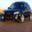

In [3]:
p = model_config.getModelDirectory()

if IS_LORA:
    tokenizer, text_encoder, vae, _ = model_config.loadModelComponents("stable-diffusion-v1-5/stable-diffusion-v1-5")
    unet = model_config.loadLoRAUnet(p,0)
    ckpts = range(model_config.NUM_CHECKPOINTS)
else:
    ckpts = model_config.loadCheckpoints(p, CONVERT_SAFETENSORS_TO_CKPT=False)
    tokenizer, text_encoder, vae, unet = model_config.loadModelComponents(p)

if IS_LORA:
    lora_layers = []
    lora_layers_filter = filter(lambda p: p[1].requires_grad, unet.named_parameters())
    for layer in lora_layers_filter:
        lora_layers.append(layer[0])
else:
    lora_layers = None

if project_config.IS_CUDA:
    text_encoder.to("cuda")
    vae.to("cuda")
    unet.to("cuda")

# Freeze vae and text_encoder
vae.requires_grad_(False)
text_encoder.requires_grad_(False)


train_dataset = dataset_config.preprocess(tokenizer)
print(train_dataset)

# DataLoaders creation:
train_dataloader = DataLoader(
    train_dataset,
    shuffle=False,
    collate_fn=dataset_config.collate_fn,
    batch_size=1,
)

dataset_config.dataset[6]['image']
train_dataset[6]["image"]

In [4]:
from trak import TRAKer
from TRAK.SD1ModelOutput import SD1ModelOutput

traker = TRAKer(model=unet,
                task=SD1ModelOutput,
                train_set_size=len(train_dataloader.dataset),
                save_dir=TRAK_SAVE_DIR,
                proj_max_batch_size=8, #Default 32, requires an A100 apparently
                proj_dim=1024,
                grad_wrt=lora_layers
                )

INFO:TRAK:('the max chunk size is 536870911, ', 'while the model has the following chunk sizes', '[518725376, 341592772].')
INFO:TRAK:Using ChunkedCudaProjector with2 chunks of sizes[518725376, 341592772].
INFO:TRAK:Initializing projector with grad_dim 797184
INFO:TRAK:Initialized projector with proj_dim 1024


INFO:STORE:Existing model IDs in /home/joy/Lboro/CodeServer/git/Data-Attribution-for-Stable-Diffusion/TRAK/trak_results_lora: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
INFO:STORE:Model IDs that have been finalized: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
INFO:STORE:No existing TRAK scores in /home/joy/Lboro/CodeServer/git/Data-Attribution-for-Stable-Diffusion/TRAK/trak_results_lora.


In [5]:
#Scoop whatever VRAM we can because this is going to be a tight fit
import gc
gc.collect()
torch.cuda.empty_cache()

Dataset({
    features: ['image', 'label_txt'],
    num_rows: 10
})
frog


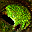

In [6]:
dummy_dataset_path = "./generated_images/1"
seed = 1
generator = torch.Generator(device="cuda").manual_seed(seed)

dummy_dataset = load_dataset('imagefolder', data_dir=dummy_dataset_path, split='train')

#Purely to keep consistent this with the source dataset
if dataset_config.image_column != "image":
    dummy_dataset = dummy_dataset.rename_column("image", dataset_config.image_column)
cl = dummy_dataset.features["label"]

#dummy_dataset = dummy_dataset.map(convertLabel)
dummy_dataset = dummy_dataset.map(lambda x, cIn, cOut: {cOut: cl.int2str(x[cIn])}, 
                                        fn_kwargs={
                                            "cIn": "label", 
                                            "cOut": dataset_config.caption_column
                                            }
                                        )

dummy_dataset = dummy_dataset.remove_columns(column_names=["label"])

print(dummy_dataset)
print(dummy_dataset[6][dataset_config.caption_column])
dummy_dataset[6][dataset_config.image_column]

In [7]:
preprocessed_dummy_dataset = dummy_dataset.with_transform(dataset_config.preprocess_train)

dummy_dataloader = DataLoader(
    preprocessed_dummy_dataset,
    shuffle=False,
    collate_fn=dataset_config.collate_fn,
    batch_size=1,
)

In [8]:
weight_dtype = torch.float32

if IS_LORA:
     experiment_name = "SD1_CIFAR10_v2_LoRA"
else:
     experiment_name = "SD1_CIFAR10_v2"


if UPDATE_SCORES:
    for model_id, ckpt in enumerate(tqdm(ckpts)):
        if IS_LORA:
            #TODO: fix the horrid local/global unet duplication going on here
            unet = model_config.loadLoRAUnet(p,ckpt)
            ckpt_local = unet.state_dict()
        else:
            ckpt_local = ckpt

        traker.start_scoring_checkpoint(exp_name=experiment_name,

                                            checkpoint=ckpt_local,

                                            model_id=model_id,

                                            num_targets=len(dummy_dataloader.dataset))
        

        for batch in tqdm(dummy_dataloader):
                if project_config.IS_CUDA:
                    batch = [x.cuda() for y,x in batch.items()]
                else:
                    batch = [x for y,x in batch.items()]
                image = batch[0]
                tokens = batch[1]
                # Convert images to latent space
                latents = vae.encode(image.to(weight_dtype)).latent_dist.sample()
                latents = latents * vae.config.scaling_factor
                encoder_hidden_states = text_encoder(tokens, return_dict=False)[0]

                batch = [latents, encoder_hidden_states]
                traker.score(batch=batch, num_samples=batch[0].shape[0])

    scores = traker.finalize_scores(exp_name=experiment_name)

  0%|          | 0/10 [00:00<?, ?it/s]/home/joy/miniconda3/envs/SD3HF_Unstable/lib/python3.10/site-packages/diffusers/models/attention_processor.py:2358: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::_scaled_dot_product_efficient_attention. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538438429/work/aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  hidden_states = F.scaled_dot_product_attention(
/home/joy/miniconda3/envs/SD3HF_Unstable/lib/python3.10/site-packages/torch/autograd/graph.py:768: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::_scaled_dot_product_efficient_attention_backward. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538438429/work/aten/src/ATen/functorch/BatchedFallback.c

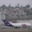

In [9]:
train_dataset[0]["image"]

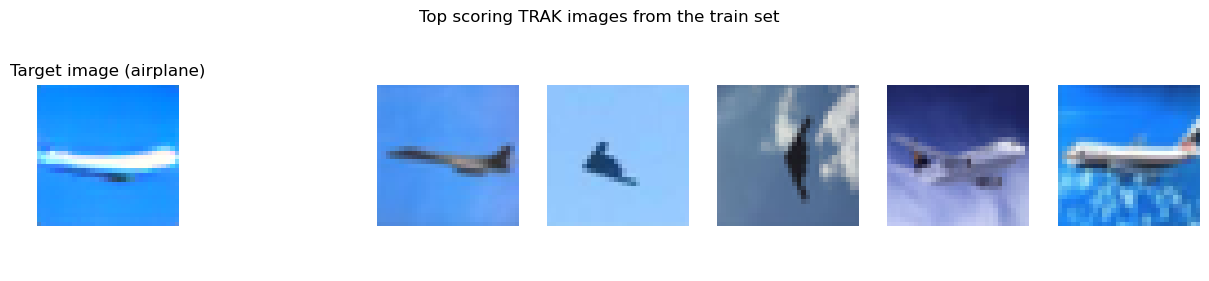

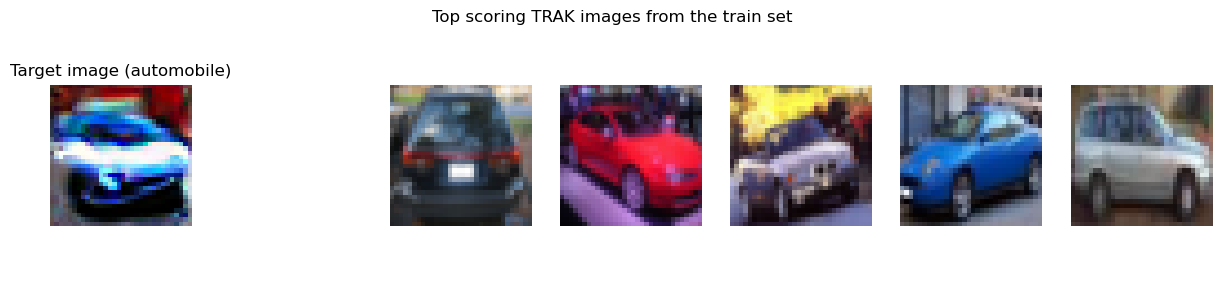

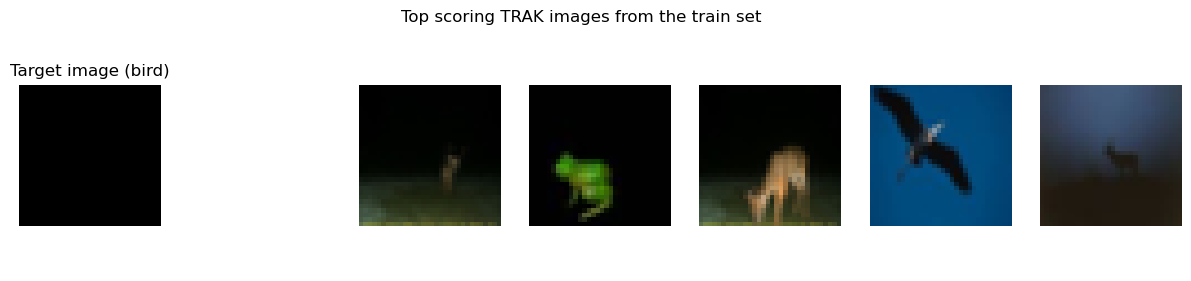

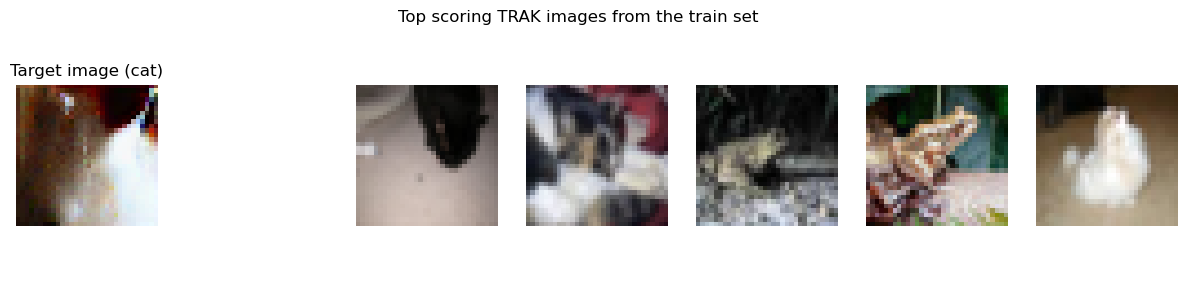

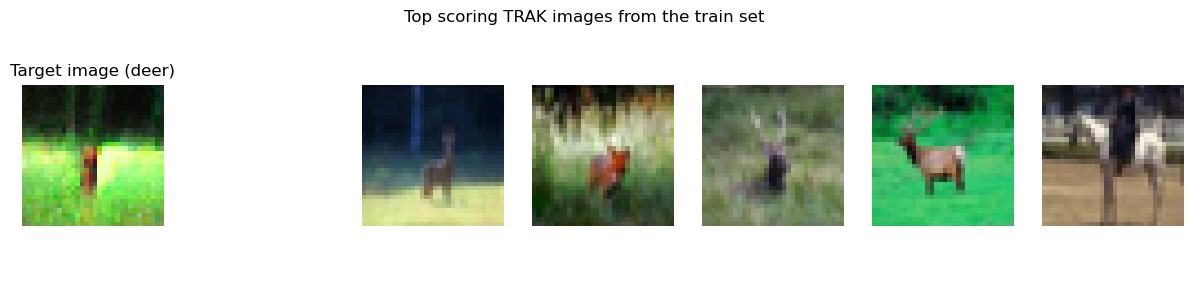

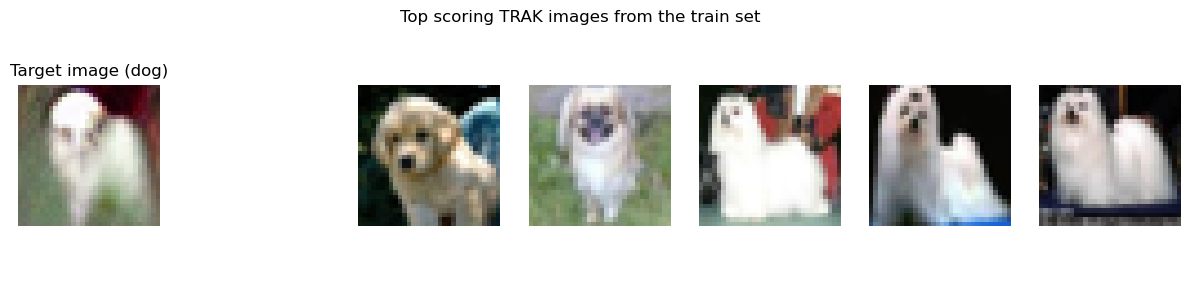

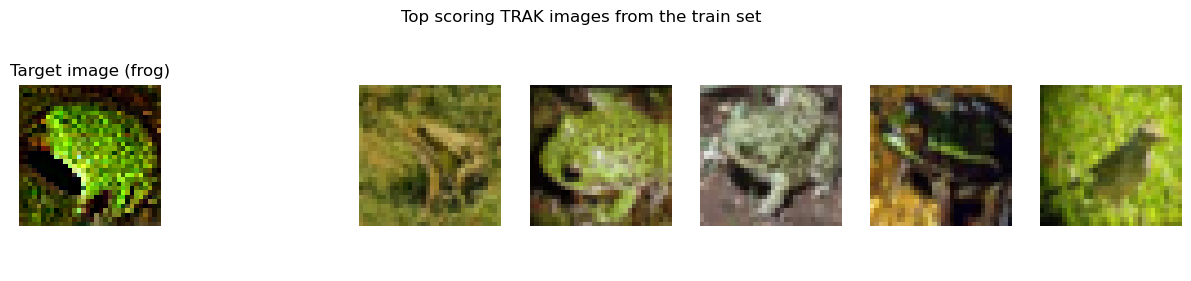

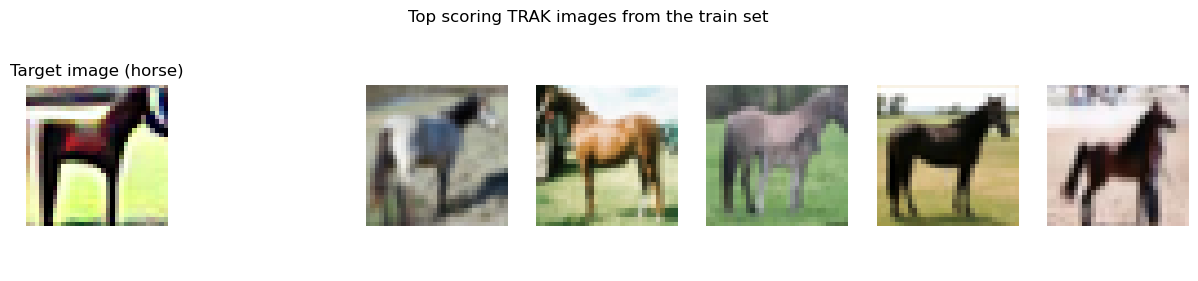

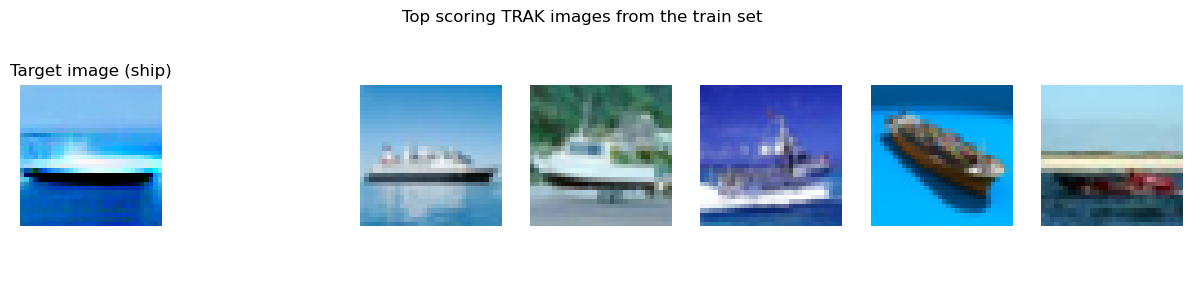

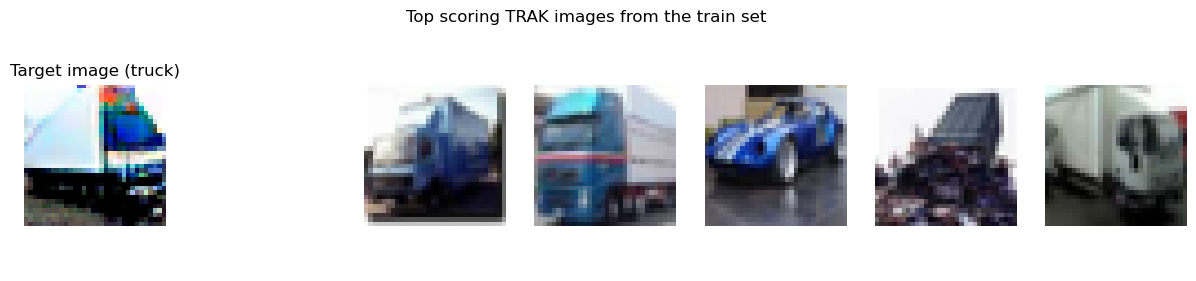

In [10]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

#Adapted from https://github.com/MadryLab/trak/blob/main/examples/cifar_quickstart.ipynb

from numpy.lib.format import open_memmap

memmap_path = ("." + 
               project_config.folder_symbol + 
               TRAK_SAVE_DIR + 
               project_config.folder_symbol +
               "scores" +
               project_config.folder_symbol +
               experiment_name +
               ".mmap")
scores = open_memmap(memmap_path)

for i in range(10): #[6]:

    fig, axs = plt.subplots(ncols=7, figsize=(15, 3))
    fig.suptitle('Top scoring TRAK images from the train set')
    
    axs[0].imshow(dummy_dataset[i][dataset_config.image_column])
    
    axs[0].axis('off'); axs[0].set_title('Target image' + " (" + dummy_dataset[i][dataset_config.caption_column] + ")")
    axs[1].axis('off')
    
    top_trak_scorers = scores[:, i].argsort()[-5:][::-1]
    for ii, train_im_ind in enumerate(top_trak_scorers):
        axs[ii + 2].imshow(train_dataset[int(train_im_ind)][dataset_config.image_column]); axs[ii + 2].axis('off')

    fig.show()